In [13]:
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np
import pickle
from tensorflow_helper import multiclass_pred_new_image_plotly, load_and_prep_image, visualize_images_tf_way
import pandas as pd
import efficientnet.tfkeras as efn
from sklearn.preprocessing import LabelEncoder

In [14]:
train_dir = "C:/Users/56976/Desktop/courses&datasets/main_datasets/food_vis_10_classes/train/"
test_dir = "C:/Users/56976/Desktop/courses&datasets/main_datasets/food_vis_10_classes/test/"

tf.random.set_seed(42)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=None, #0.2
    seed=42,
    subset=None, #"training"
    image_size=(224, 224),  #Height, width
    batch_size=32,
    shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=42,
    validation_split=None, #0.2
    subset=None,   #validation"
    image_size=(224, 224),
    batch_size=32,
    shuffle=True)

class_names = train_ds.class_names

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [15]:
label_encoder = LabelEncoder().fit(class_names)

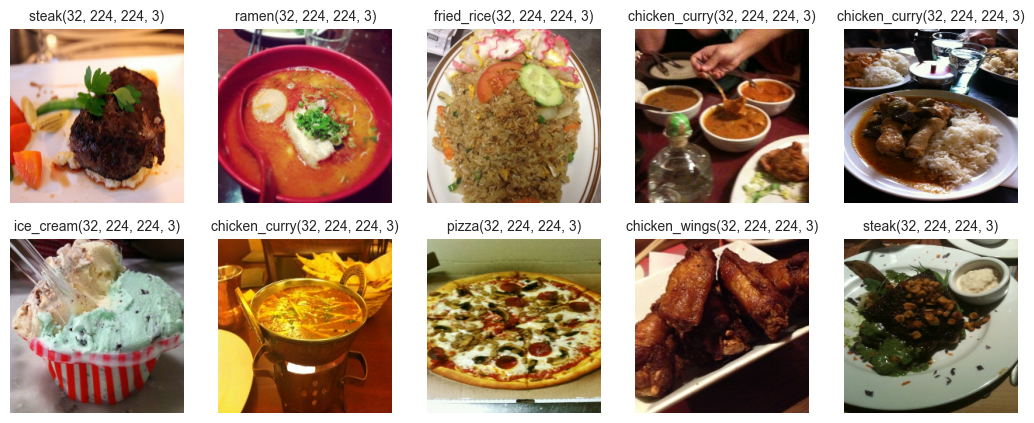

In [16]:
visualize_images_tf_way(train_ds, class_names=class_names)

In [17]:
checkpoint_path = "weights_checkpoints/checkpoint_food_vision/CP1"

# Create a ModelCheckpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True
                                                         ,verbose=1, save_freq="epoch")

In [18]:
# from tensorflow.keras import mixed_precision
#
# policy = mixed_precision.Policy("mixed_float16")
# mixed_precision.set_global_policy(policy)

In [19]:
# Setup the input shape and base model. freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False, include_preprocessing=True)
base_model.trainable = False


inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer") #Inputs
#x = data_augmentation(inputs)               # Add data augmentation
x = base_model(inputs,training=False)          #Give base_model the inputs after augmentation, makes sure batch norm layers doesnt change
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer_2d", dtype="float32")(x) # Pool output features of the base model.
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output_layer", dtype="float32")(x)  #Dense layer as output



optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


model = tf.keras.Model(inputs,outputs)  #Make the model
sam_optimizer = tf.keras.models.experimental.SharpnessAwareMinimization(model, rho=0.05, num_batch_splits=None)
sam_optimizer.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model = tf.keras.Model(inputs,outputs)  #Make the model

# model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               metrics=["accuracy"])

in_epoch = 5

hist = sam_optimizer.fit(train_ds, steps_per_epoch=len(train_ds), validation_data=val_ds,
                 validation_steps=(len(val_ds)),
                 epochs=in_epoch, verbose=1, callbacks=[checkpoint_callback])

52606240/52606240 [==============================] - 3s 0us/step
Epoch 1/5
235/235 [==============================] - ETA: 0s - loss: 0.7673 - accuracy: 0.7903
Epoch 1: val_loss improved from inf to 0.37097, saving model to weights_checkpoints/checkpoint_food_vision\CP1
235/235 [==============================] - 58s 192ms/step - loss: 0.7673 - accuracy: 0.7903 - val_loss: 0.3710 - val_accuracy: 0.8864
Epoch 2/5
235/235 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.8736
Epoch 2: val_loss improved from 0.37097 to 0.30616, saving model to weights_checkpoints/checkpoint_food_vision\CP1
235/235 [==============================] - 42s 178ms/step - loss: 0.4403 - accuracy: 0.8736 - val_loss: 0.3062 - val_accuracy: 0.9032
Epoch 3/5
235/235 [==============================] - ETA: 0s - loss: 0.3712 - accuracy: 0.8916
Epoch 3: val_loss improved from 0.30616 to 0.28211, saving model to weights_checkpoints/checkpoint_food_vision\CP1
235/235 [==============================] 

In [20]:
# to begin fine-tuning, let's start by setting the last 18 layers of our base_model.trainable = True
base_model.trainable = True

#Freeze all layers except for the last 18
for layer in base_model.layers[:-36]:
    layer.trainable = False


# Recompile (we have to recompile our models everytime we make a change)
# I should make a very low learning rate when i start fine-tuning, thumb rule. lower lr by 10x.
sam_optimizer.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [21]:
checkpoint_path = "weights_checkpoints/checkpoint_food_vision/CP1"

# Create a ModelCheckpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True
                                                         ,verbose=1, save_freq="epoch")

In [22]:
in_epoch = hist.epoch[-1] # start training from previous last epoch.
fine_tune_epochs = in_epoch + 10

hist = sam_optimizer.fit(train_ds, steps_per_epoch=len(train_ds), validation_data=val_ds,
                                               validation_steps=(len(val_ds)),
                                               epochs=fine_tune_epochs, initial_epoch=in_epoch,  verbose=1,
                                               callbacks=[checkpoint_callback])

Epoch 5/14
235/235 [==============================] - ETA: 0s - loss: 0.2935 - accuracy: 0.9272
Epoch 5: val_loss improved from inf to 0.23453, saving model to weights_checkpoints/checkpoint_food_vision\CP1
235/235 [==============================] - 63s 207ms/step - loss: 0.2935 - accuracy: 0.9272 - val_loss: 0.2345 - val_accuracy: 0.9216
Epoch 6/14
235/235 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9563
Epoch 6: val_loss improved from 0.23453 to 0.22207, saving model to weights_checkpoints/checkpoint_food_vision\CP1
235/235 [==============================] - 47s 199ms/step - loss: 0.2058 - accuracy: 0.9563 - val_loss: 0.2221 - val_accuracy: 0.9228
Epoch 7/14
235/235 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.9815
Epoch 7: val_loss improved from 0.22207 to 0.21320, saving model to weights_checkpoints/checkpoint_food_vision\CP1
235/235 [==============================] - 47s 199ms/step - loss: 0.1284 - accuracy: 0.9815 - val_loss:

In [23]:
sam_optimizer.load_weights("weights_checkpoints/checkpoint_food_vision/CP1")

In [12]:
model.save("food_vis_model_sam.h5")

2023-03-26 22:33:24.320 WARNING tensorflow: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
